## Sprint 3 Trees
### By Sahar Mohamed

#### Instructions
Sprint on Trees - Activity 3: Build your own Pattern Spectrum!

    Select some EO data that contain objects/structures of interest
    Design specific attribute(s) that would be useful to identify the elements of interest
    Write a Jupyter Notebook that extract automatically the elements of interest from the data
    Assess your solution on several images, and discuss its relevance
    Complete the notebook with description and justification of the attributes used, and clear explanations of the different steps in the process

Remark: the features you will use/suggest could be added to the core SAP library!

In [1]:
from pathlib import Path # Manage folders and files
import rasterio as rio # Reads and writes geospatial raster data
from matplotlib import pyplot as plt # Display plots and images
import numpy as np # Multi-dimensional arrays
import sap # To create morphological trees
import higra as hg # High-performance image processing

In [ ]:
## Download sample data from open aerial map website
#!wget https://oin-hotosm-temp.s3.amazonaws.com/5bc82ffd9ca0a4000742a12b/0/5bc82ffd9ca0a4000742a12c.tif

--2025-12-17 06:30:02--  https://oin-hotosm-temp.s3.amazonaws.com/5bc82ffd9ca0a4000742a12b/0/5bc82ffd9ca0a4000742a12c.tif
Resolving oin-hotosm-temp.s3.amazonaws.com (oin-hotosm-temp.s3.amazonaws.com)... 16.182.41.129, 52.217.174.57, 52.217.233.1, ...
Connecting to oin-hotosm-temp.s3.amazonaws.com (oin-hotosm-temp.s3.amazonaws.com)|16.182.41.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4945799 (4.7M) [binary/octet-stream]
Saving to: ‘5bc82ffd9ca0a4000742a12c.tif’

5bc82ffd9ca0a400074 100%[===================>]   4.72M  3.38MB/s    in 1.4s    

2025-12-17 06:30:04 (3.38 MB/s) - ‘5bc82ffd9ca0a4000742a12c.tif’ saved [4945799/4945799]



In [2]:
# Load Drone image for saudi arabia site
image = Path('5bc82ffd9ca0a4000742a12c.tif')
with rio.open(image) as src:
    img = src.read(1)  # Read the first band (grayscale)
    profile = src.profile  # Get metadata
print(profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 7410, 'height': 8119, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 39N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32639"]]'), 'transform': Affine(0.04999470842140711, 0.0, 211440.99395795987,
       0.0, -0.049998891233369175, 3251103.426790202), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'jpeg', 'interleave': 'pixel', 'photometric': 'ycbcr'}


In [3]:
print(img.dtype)

print (img.shape)

uint8
(8119, 7410)


(8119, 7410)


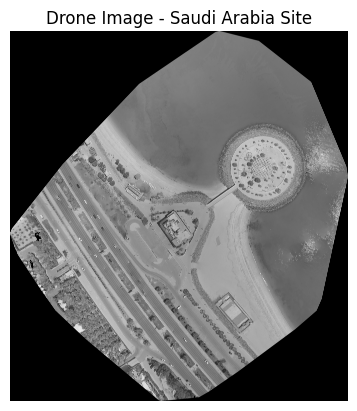

In [4]:
## shap of the image
print(img.shape)  # (bands, height, width)

# normalize to [0, 255]
img = (img - img.min()) / (img.max() - img.min())
img = (img * 255)
img = img.astype(np.uint8)

# Display the image
plt.imshow(img, cmap='gray')
plt.title('Drone Image - Saudi Arabia Site')
plt.axis('off')
plt.show()


In [6]:
img.dtype

dtype('uint8')

### I want to xtract the water and then the rodas , just to see what will happen
### my objects of interest are (from papers water , it's dark and homogenous so min tree+ area or std )
### second is roads ( bright and eleogated shape , so Maxtree and area +moment of inertia)

In [33]:
## convert image to numpy array
img_array = np.array(img).astype(np.float32)
print(img_array.dtype)

float32


In [22]:
## building the trees using Higra

# max_tree, node_attributes = hg.max_tree(img, connectivity=hg.get_4_connected_graph(img.shape))
# print(f'Number of nodes in the max-tree: {max_tree.num_vertices()}')
# # Using Sap to build the max-tree
# max_tree_sap = sap.MaxTree(img)
# print(f'Number of nodes in the Sap max-tree: {max_tree_sap.num_nodes()}')

## smooth the image using a Gaussian filter
from scipy.ndimage import gaussian_filter
img_smooth = gaussian_filter(img, sigma=2)

# Max-tree (bright objects (roads))
tree_max = sap.MaxTree(img_smooth)
print(f'Number of nodes in the max-tree: {tree_max.num_nodes}')

# Min-tree (dark objects (water))
tree_min = sap.MinTree(img_smooth)
print(f'Number of nodes in the min-tree: {tree_min.num_nodes}')


Number of nodes in the max-tree: <bound method Tree.num_nodes of MaxTree{'adjacency': 4,
 'image.dtype': dtype('uint8'),
 'image.shape': (8119, 7410),
 'image_hash': '1f7e4edb',
 'image_name': None,
 'num_nodes': 60624553}>
Number of nodes in the min-tree: <bound method Tree.num_nodes of MinTree{'adjacency': 4,
 'image.dtype': dtype('uint8'),
 'image.shape': (8119, 7410),
 'image_hash': '1f7e4edb',
 'image_name': None,
 'num_nodes': 60637455}>


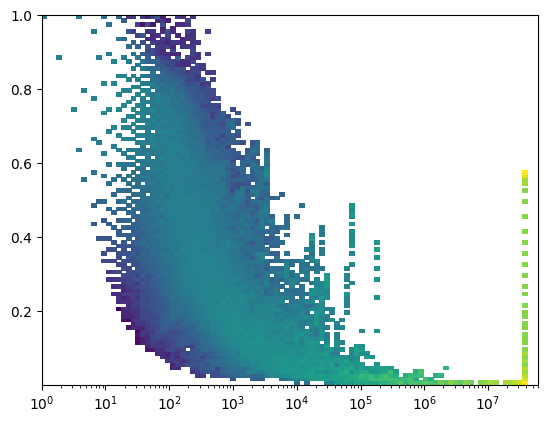

In [23]:
## draw pattern spectra for max-tree and min-tree

pattern_spectra_max = sap.spectrum2d(tree_max, 'area', 'compactness', x_log=True)
pattern_spectra_min = sap.spectrum2d(tree_min, 'area', 'compactness', x_log=True)


sap.show_spectrum(*pattern_spectra_max) # Display max-tree pattern spectra




# plt.figure(figsize=(10, 5))
# plt.plot(pattern_spectra_max, label='Max-Tree Pattern Spectra', color='blue')
# plt.plot(pattern_spectra_min, label='Min-Tree Pattern Spectra', color='orange')
# plt.title('Pattern Spectra')
# plt.xlabel('Node Index')
# plt.ylabel('Attribute Value')
# plt.legend()
# plt.show()

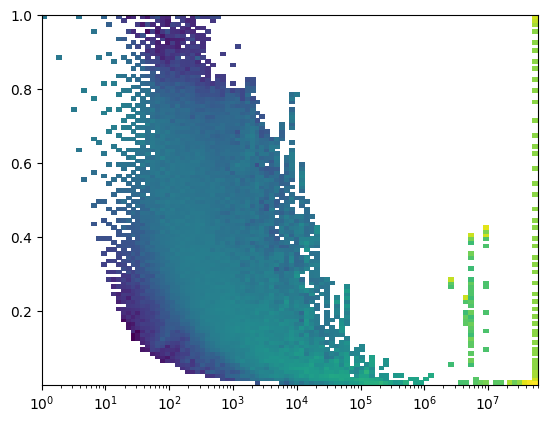

In [24]:
sap.show_spectrum(*pattern_spectra_min) # Display min-tree pattern spectra

In [25]:

area_max = tree_max.get_attribute("area")  # Compute area attribute
compact_max = tree_max.get_attribute("compactness")  # Compute compactness attribute
moment_max = tree_max.get_attribute("moment_of_inertia")  # Compute moment attribute

print('area', area_max[:50])
print("---------------------------------")
print('compactness', compact_max[:50])
print("---------------------------------")
print('moment', moment_max[:50])

area [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
---------------------------------
compactness [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
---------------------------------
moment [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [26]:
print(area_max.shape)
## range of attributes

print(f"Area range: [{area_max.min():.2f}, {area_max.max():.2f}]")
print(f"Compactness range: [{compact_max.min():.4f}, {compact_max.max():.4f}]")
print(f"Moment of Inertia range: [{moment_max.min():.4f}, {moment_max.max():.4f}]")

(60624553,)
Area range: [1.00, 60161790.00]
Compactness range: [0.0007, 1.0000]
Moment of Inertia range: [0.0000, 13.2304]


In [ ]:
tree_max.available_attributes()

## What are edge_weights in image trees?

For image-based trees (min-tree / max-tree):

the leaf graph is the pixel grid (4- or 8-connected)

edge weights = contrast between neighboring pixels

In [27]:
## attributes for min-tree
area_min = tree_min.get_attribute("area")  # Compute area attribute
compact_min = tree_min.get_attribute("compactness")  # Compute compactness attribute
moment_min = tree_min.get_attribute("moment_of_inertia")  # Compute moment attribute


print('area', area_min[:50])
print("---------------------------------")
print('compactness', compact_min[:50])
print("---------------------------------")
print('moment', moment_min[:50])

## ranges
print(f"Area range: [{area_min.min():.2f}, {area_min.max():.2f}]")
print(f"Compactness range: [{compact_min.min():.4f}, {compact_min.max():.4f}]")
print(f"Moment of Inertia range: [{moment_min.min():.4f}, {moment_min.max():.4f}]")


area [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
---------------------------------
compactness [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
---------------------------------
moment [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Area range: [1.00, 60161790.00]
Compactness range: [0.0014, 1.0000]
Moment of Inertia range: [0.0000, 19.6312]


## Fixed Threshold for water and rodas

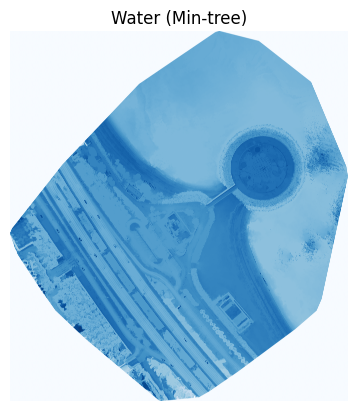

In [54]:
# recompute attributes after smoothing

water_nodes = (
    (area_min > 1000000) &      # large regions
    (moment_min < 1)         # homogeneous
)

water_mask = tree_min.reconstruct(~water_nodes)

plt.imshow(water_mask, cmap="Blues")
plt.title("Water (Min-tree)")
plt.axis("off")
plt.show()




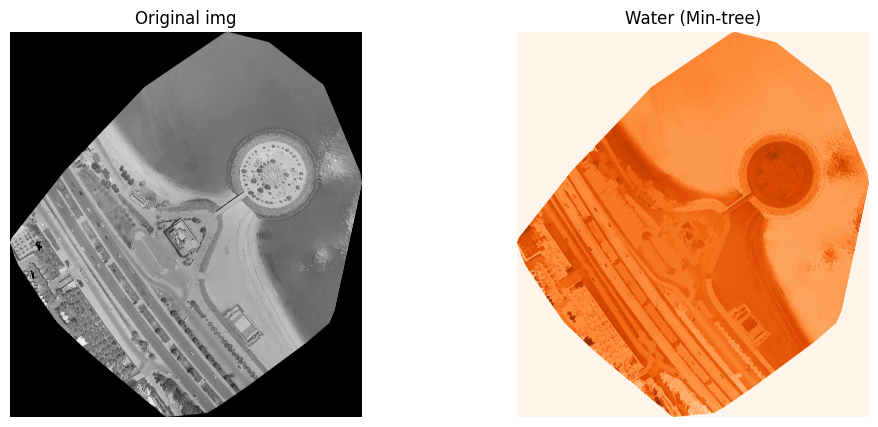

In [49]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_smooth, cmap='gray')
plt.title("Original img")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(water_mask, cmap='Oranges')
plt.title("Water (Min-tree)")
plt.axis("off")

plt.show()

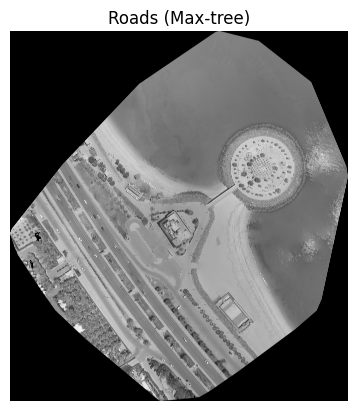

In [56]:
## rodas
road_nodes = (
    (area_max > 500) &
    (area_max < 5000) &
    (moment_max > 8) &
    (compact_max < 0.6)
)

road_mask = tree_max.reconstruct(road_nodes)

plt.imshow(road_mask, cmap="gray")
plt.title("Roads (Max-tree)")
plt.axis("off")
plt.show()



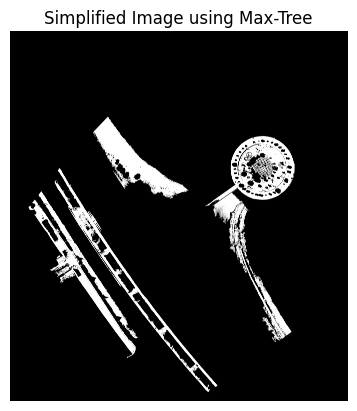

In [ ]:
## max tree for extract other objects rather than water

image = img / 255 # normalize image to [0, 1]

graph = hg.get_4_adjacency_implicit_graph(image.shape) # get 4-adjacency graph 
tree, altitudes = hg.component_tree_max_tree(graph, image) # build max-tree
volume = hg.attribute_volume(tree, altitudes) # compute volume attribute for simplification

tree, node_map = hg.simplify_tree(tree, volume < 100000) # simplify tree based on volume attribute
altitudes = altitudes[node_map] # update altitudes after simplification
extr = hg.attribute_extrema(tree, altitudes) # get extrema attribute for reconstruction

res = hg.reconstruct_leaf_data(tree, extr) # reconstruct simplified image

# plottig
plt.imshow(res, cmap='gray')
plt.title('Simplified Image using Max-Tree')
plt.axis('off')
plt.show()

In [39]:
volume.min(), volume.max()

(np.float64(0.0), np.float64(20652949.717651516))

In [ ]:
## max tree for extract other objects rather than water

## delete background objects
img[img == 0] = 255

image = img # normalize image to [0, 1]

graph = hg.get_4_adjacency_implicit_graph(image.shape) # get 4-adjacency graph 
tree, altitudes = hg.component_tree_max_tree(graph, image) # build max-tree
volume = hg.attribute_volume(tree, altitudes) # compute volume attribute for simplification

tree, node_map = hg.simplify_tree(tree, volume < 2000000) # simplify tree based on volume attribute
altitudes = altitudes[node_map] # update altitudes after simplification
extr = hg.attribute_extrema(tree, altitudes) # get extrema attribute for reconstruction

res = hg.reconstruct_leaf_data(tree, extr) # reconstruct simplified image

# plottig
plt.imshow(res, cmap='Oranges')
plt.title('Simplified Image using Max-Tree')
plt.axis('off')
plt.show()

In [23]:
image = img / 255.0
imge_inv = 1.0 - image  # Invert image for water extraction
imge_inv.dtype

image.dtype

dtype('float64')

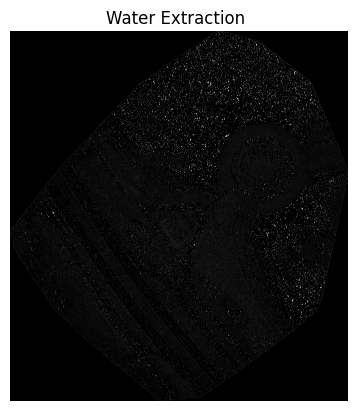

In [36]:


# Build graph and max-tree
image = img / 255.0
graph = hg.get_8_adjacency_implicit_graph(image.shape)
tree, altitudes = hg.component_tree_max_tree(graph, image)

#  area attribute 
area = hg.attribute_area(tree)
mi = hg.attribute_moment_of_inertia(tree)
#compactness = hg.attribute_compactness(tree)

# Filter nodes by area
area_thr = 10000000
keep_nodes = (area >= area_thr)  & (mi <= 4)

# Simplify tree using area
tree_s, node_map = hg.simplify_tree(tree, keep_nodes)
altitudes_s = altitudes[node_map]

# Select extrema (water basins)
extrema = hg.attribute_extrema(tree_s, altitudes_s)

# Reconstruct water mask
water_mask = hg.reconstruct_leaf_data(tree_s, extrema)

# Display
plt.imshow(water_mask, cmap="gray")
plt.title("Water Extraction ")
plt.axis("off")
plt.show()


In [57]:
## water detection using min-tree and area attribute
water_area_thr_min, water_area_thr_max = 1000, 5000
water_mom_thr_min, water_mom_thr_max = 2, 4

water_nodes = (
    (area_min >= water_area_thr_min) &
    (area_min <= water_area_thr_max) &
    (moment_min  >= water_mom_thr_min) &
    (moment_min  <= water_mom_thr_max)
)



print(f"Number of water regions detected: {len(water_nodes)}")
print("Water nodes:", np.sum(water_nodes))

## reconstruct water mask from min-tree
water_mask = tree_min.reconstruct(water_nodes)


Number of water regions detected: 62877232
Water nodes: 402


## Fixed Thresholds

In [ ]:
## rodas detection using max-tree and area attribute
road_area_thr   = 3000
road_moment_thr = 10
road_comp_thr   = 0.6   

road_nodes = (
    (area_max   <= road_area_thr) &
    (moment_max >= road_moment_thr) &
    (compact_max <= road_comp_thr)
)
print("Road nodes:", np.sum(road_nodes))


#3 reconstruct road mask from max-tree
road_mask = tree_max.reconstruct(road_nodes) > 0



Road nodes: 38


In [ ]:
## mask image for the selected nodes of roads
road_nodes2 = (
    (area_max   < 3000) &          # small
    (moment_max > 10) &             # elongated
    (compact_max < 0.5) &           # not compact
    (~border_nodes)                 # NOT touching image border
)

road_mask2 = tree_max.reconstruct(road_nodes2) > 0

print(road_mask2.dtype)
print (np.sum(road_nodes2))

bool
38


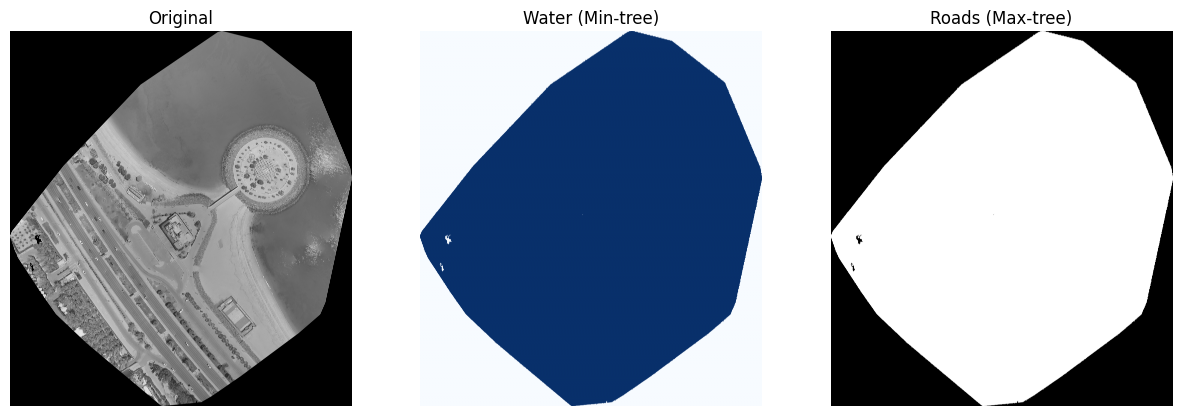

In [ ]:
# Display original image, water mask, and road mask
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(water_mask, cmap="Blues")
plt.title("Water (Min-tree)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(road_mask2, cmap="gray")
plt.title("Roads (Max-tree)")
plt.axis("off")

plt.show()


In [45]:
H, W = img.shape
node_pixels = tree_max.get_attribute("vertex_list")


def touches_border(pixels):
    ys, xs = np.unravel_index(pixels, (H, W))
    return (
        np.any(xs == 0) or np.any(xs == W-1) or
        np.any(ys == 0) or np.any(ys == H-1)
    )

border_nodes = np.array([touches_border(p) for p in node_pixels])


## another trial 

In [15]:
from scipy.signal import find_peaks

# Min-tree (water)
bins_min, values_min = pattern_spectra_min
peaks_min, _ = find_peaks(values_min, height=0.05)

# Max-tree (roads)
bins_max, values_max = pattern_spectra_max
peaks_max, _ = find_peaks(values_max, height=0.05)

print("Water peaks at areas:", bins_min[peaks_min])
print("Road peaks at areas:", bins_max[peaks_max])


ValueError: too many values to unpack (expected 2)

In [ ]:
# min tree for water extraction


graphw = hg.get_4_adjacency_implicit_graph(image.shape) # get 4-adjacency graph 
treew= hg.component_tree_min_tree(graphw, image) # build min-tree
area = hg.attribute_area(treew) # compute area attribute for simplification

treew, node_mapw = hg.simplify_tree(treew, area > 100000) # simplify tree based on area attribute

resw = hg.reconstruct_leaf_data(treew) # reconstruct simplified image

# plotting
plt.imshow(resw, cmap='Blues')
plt.title('Simplified Image using Min-Tree')
plt.axis('off')
plt.show()

In [ ]:
# mask image for the selected nodes
node_mask_water = np.zeros(img.size, dtype=bool)


all_vertices = hg.attribute_vertex_list(tree_min._tree)

for node_id, selected in enumerate(water_nodes):
    if selected:
        pixels = all_vertices[node_id]  # list of leaf pixels in the node
        node_mask_water[pixels] = True

print("Number of pixels selected:", np.sum(node_mask_water))





In [ ]:
node_mask_water_2d = node_mask_water.reshape(img.shape)
print(node_mask_water_2d.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(node_mask_water_2d, cmap='gray')
plt.title("Water pixels")
plt.axis("off")
plt.show()
# Display before and after
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='viridis')
plt.title("Original img")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(node_mask_water_2d, cmap='viridis')
plt.title("Water filtered")
plt.axis("off")

plt.show()

In [53]:
## extracting objects based on area and compactness thresholds
area_threshold = 500  #  area threshold
compactness_threshold = 0.5  # compactness threshold
moment_threshold = 0.1  # moment threshold

# Filter nodes in max-tree based on thresholds
selected_nodes_max = [i for i in range(tree_max.num_nodes) if area_max[i] >= area_threshold and compact_max[i] <= compactness_threshold and moment_max[i] >= moment_threshold]
print(f'Number of selected nodes in max-tree: {len(selected_nodes_max)}')

# Filter nodes in min-tree based on thresholds
selected_nodes_min = [i for i in range(tree_min.num_nodes) if area_min[i] >= area_threshold and compact_min[i] <= compactness_threshold and moment_min[i] >= moment_threshold]
print(f'Number of selected nodes in min-tree: {len(selected_nodes_min)}')   

## plotting objects extracted from max-tree and min-tree
# Create binary masks for selected nodes
mask_max = np.zeros(img.shape, dtype=np.uint8)
for node in selected_nodes_max:
    pixels = tree_max.get_node_pixels(node)
    mask_max[pixels[:, 0], pixels[:, 1]] = 255


mask_min = np.zeros(img.shape, dtype=np.uint8)
for node in selected_nodes_min:
    pixels = tree_min.get_node_pixels(node)
    mask_min[pixels[:, 0], pixels[:, 1]] = 255  
    
# Display the masks
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(mask_max, cmap='gray')   
plt.title('Extracted Objects from Max-Tree (Bright Objects)')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mask_min, cmap='gray')   
plt.title('Extracted Objects from Min-Tree (Dark Objects)')
plt.axis('off')
plt.show()

TypeError: 'method' object cannot be interpreted as an integer

In [ ]:
leaf_graph = hg.get_4_adjacency_graph(img.shape)  # compute leaf graph
edge_weights = hg.weight_graph( # edge weights for contour strenght
    leaf_graph,
    img,
    hg.WeightFunction
)

contour_strength_min = tree_min.get_attribute("contour_strength",edge_weights=edge_weights, leaf_graph = leaf_graph )  # Compute contour strength attribute


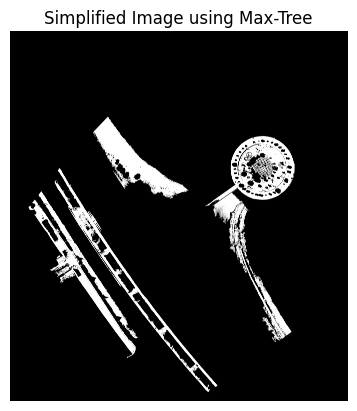